In [4]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [5]:
image_directory = '../voc_multi_semantic_seg_dataset/PNGImages/*'
mask_directory = '../voc_multi_semantic_seg_dataset/SegmentationClassPNG/*'

In [6]:
image_names = glob.glob(image_directory)
image_names

['../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_13-57-46.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-00-47.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-00.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-04.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-09.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-21.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-28.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-38.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-42.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-50.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-01-57.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-02-02.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-12-2022_14-02-47.png',
 '../voc_multi_semantic_seg_dataset/PNGImages\\28-1

In [7]:
mask_names = glob.glob(mask_directory)
mask_names

['../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_13-57-46.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-00-47.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-00.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-04.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-09.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-21.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-28.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-38.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-42.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-50.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-01-57.png',
 '../voc_multi_semantic_seg_dataset/SegmentationClassPNG\\28-12-2022_14-02-0

In [21]:
image_names.sort()
images = [cv2.imread(img, 0) for img in image_names]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis= 3)

In [9]:
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis= 3)

In [10]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (40, 512, 512, 1)
Mask data shape is:  (40, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0  14  19  38  52  75  89 113 128]


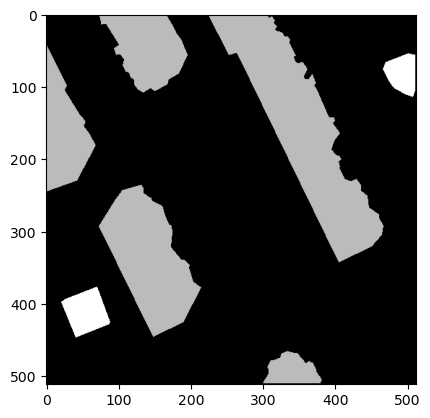

In [11]:
plt.imshow(mask_dataset[0,:,:,0], cmap='gray')

In [12]:
mask_labels = np.unique(mask_dataset)
for mask in mask_dataset:
  for i, val in enumerate(mask_labels):
    mask[mask==val] = i
print("Labels in the mask are : ", np.unique(mask_dataset))

Labels in the mask are :  [0 1 2 3 4 5 6 7 8]


In [19]:
#binary segmentation
for mask in mask_dataset:
  mask[mask>0] = 1
print("Labels in the mask are : ", np.unique(mask_dataset))

Labels in the mask are :  [0. 1.]


In [22]:
image_dataset = image_dataset /255. 
# mask_dataset = mask_dataset /255.

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 42)

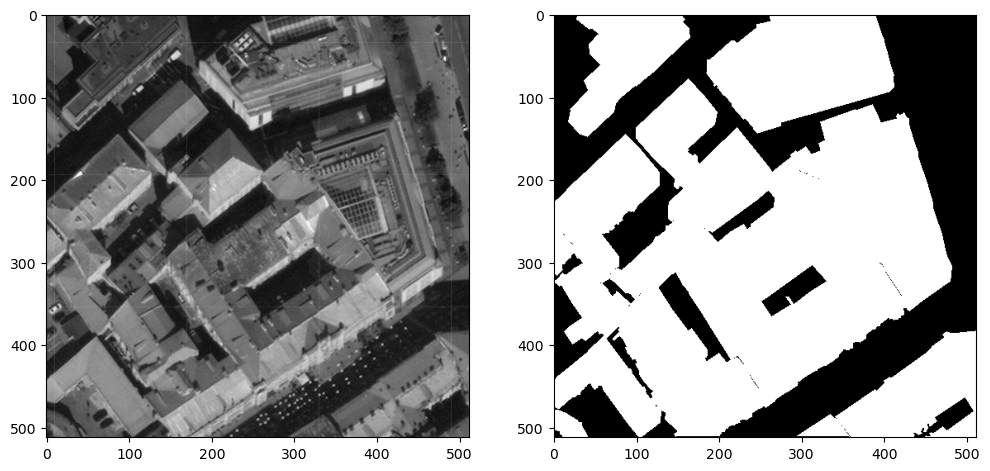

In [26]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [28]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [29]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [30]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/20


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/test.hdf5')

In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0]).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()